# Seq2Seq Builder


In this notebook we will see how to build a Seq2Seq model, to construct the source code of the seq2seq model, and also drop anything useless.

For that, we will use the following imports:
- from seq2seq.data import SeqDataset
- from seq2seq.embeddings import OneHotEmbedding
- from seq2seq.parser import parser

In [1]:
!rm -R build_test/

In [8]:
from torch.utils.data import DataLoader
from src.seq2seq.dataset import SeqDataset, pad_batch
config = {
    'device': 'cpu',
    'quiet': False,
    'batch_size': 4, 
    'max_epochs': 1,
    'valid_file' : None,
    'nworkers': 2
}
train_file='data/ArchiveII_max_length_128.csv'
batch_size = config["batch_size"] if "batch_size" in config else 4
train_loader = DataLoader(
    SeqDataset(train_file, training=True, max_len=128,**config),
    batch_size=batch_size, 
    shuffle=True,
    num_workers=2,
    collate_fn=lambda batch: pad_batch(batch, fixed_length=128)
)

In [4]:
from src.seq2seq.model import Seq2Seq

net = Seq2Seq(train_len=len(train_loader), **config)

In [5]:
train_metrics = net.fit(train_loader)

100%|██████████| 582/582 [02:27<00:00,  3.95it/s]


In [2]:
!rm -R build_test/
from src.seq2seq import train 
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("seq2seq - plain")
config = {
    'device': 'cpu',
    'batch_size': 4,
    'quiet': False,
    'max_len': 128,
    'max_epochs': 2,
    'valid_file' : None,
    'nworkers': 4
}
train_file='data/ArchiveII.csv'

out_path='./results/plain_1e'
# Llamar a train con los argumentos
train(
    train_file=train_file,
    config=config,
    out_path=out_path,
    valid_file=None,
    nworkers=4
)

UnboundLocalError: local variable 'child' referenced before assignment

In [4]:
import pandas as pd

df = pd.read_csv('data/ArchiveII.csv')
df = df.query('len <= 128')
df.iloc[0].sequence

# df.to_csv('data/ArchiveII_max_length_128.csv', index=False)

'UCUGGUGACGAUAGGUAAGAUGGUUCACCUGUUCCCAUCCCGAACACAGAAGUUAAGCAUCUUAGCGCCGACGAUAGUUAUUACAAUUAGCGAAAAUAGGACGUUGCCAGGC'

In [ ]:
from src.seq2seq import pred 

config = {
    'device': 'cpu',
    'batch_size': 4,
    'quiet': False,
    'max_len': 128,
    'max_epochs': 1,
    'valid_file' : None,
    'nworkers': 2
}
train_file='data/ArchiveII.csv'

out_path='./results/plain_100e'
# Llamar a train con los argumentos

pred(df.iloc[0].sequence, sequence_id=df.iloc[0].id, model_weights=out_path + '/weights.pmt', out_path=out_path +'/pred.csv', logits=False, config={}, nworkers=2, draw=False, draw_resolution=10, verbose=True)

Load weights from ./build_test/build_AE_seq2seq/weights.pmt
Start prediction of 5s_Acholeplasma-laidlawii-1.csv


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


<Axes: xlabel='epoch'>

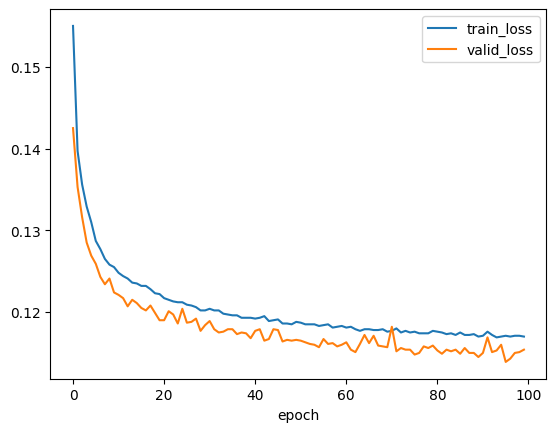

In [ ]:
log = pd.read_csv(out_path+'/train_log.csv')
log.plot(x='epoch', y=['train_loss', 'valid_loss'])

In [3]:
!rm -R ./results/plain_1e
from src.seq2seq import train 
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("seq2seq - plain")
config = {
    'device': 'cpu',
    'batch_size': 4,
    'quiet': False,
    'max_len': 128,
    'max_epochs': 3,
    'valid_file' : None,
    'nworkers': 4
}
train_file='data/ArchiveII.csv'
out_path='./results/plain_1e'
with mlflow.start_run():
    # Registrar los parámetros de configuración
    mlflow.log_params(config)
    
    # Llamar a train con los argumentos
    train(
        train_file=train_file,
        config=config,
        out_path=out_path,
        valid_file=None,
        nworkers=4
    )
    
    mlflow.log_params(config)
    

Working on ./results/plain_1e
From 3478 sequences, filtering 0 < len < 128 we have 2077 sequences
From 386 sequences, filtering 0 < len < 128 we have 249 sequences
No weights provided, using random initialization
Start training...


100%|██████████| 63/63 [00:09<00:00,  6.39it/s]


epoch,train_loss,valid_loss

0,0.1596,0.1348



100%|██████████| 63/63 [00:00<00:00, 97.40it/s] 


1,0.1292,0.1217



100%|██████████| 63/63 [00:00<00:00, 68.52it/s]


2,0.1201,0.1140

🏃 View run nebulous-rook-921 at: http://localhost:5000/#/experiments/1/runs/cdb73b14f2ca482f9f53f2ec78b70384
🧪 View experiment at: http://localhost:5000/#/experiments/1


# Pruebas

In [9]:
df_ = pd.read_csv('build_test/pred.csv')
df_

,id,sequence,length,embedding,reconstructed,latent
0,5s_Acholeplasma-laidlawii-1,UCUGGUGACGAUAGGUAAGAUGGUUCACCUGUUCCCAUCCCGAACA...,112,[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0....,[[ 0.2523379 0.08667381 0.2337942 0.13717...,[0. 0. 0. 0. 0...


In [84]:
train_iter = iter(train_loader)  
batch = next(train_iter)     

In [98]:
print(batch.keys())
print(f'length: {batch["length"]}')
print(f'contact: {batch["contact"][0].shape}')
print(f'embedding: {batch["embedding"][0].shape}') 
print(f'sequence: {len(batch["sequence"][0])}') 
 
# Suponiendo que embedding_dim = 4 (como en tu condición)
embedding = batch["embedding"][0]  # [embedding_dim, seq_len]
seq_len = embedding.shape[1]

l = [i for i in range(seq_len) 
     if (embedding[0][i] == 0 and 
         embedding[1][i] == 0 and 
         embedding[2][i] == 0 and 
         embedding[3][i] == 0)]
embedding[0]

dict_keys(['contact', 'embedding', 'length', 'canonical_mask', 'interaction_prior', 'sequence', 'id'])
length: [76, 77, 83, 78]
contact: torch.Size([83, 83])
embedding: torch.Size([4, 83])
sequence: 76


tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
import matplotlib.pyplot as plt
plt.hist([i for i in len_seq if i < 128], bins=100)